# Práctica  Escenarios de Estrés y Cambios de Régimen

## Objetivo (resumen)
Construir un motor interpretable de detección de regímenes (calma/crisis) y simulación multiactivo con cópulas,
capaz de generar escenarios de estrés y cuantificar pérdidas extremas (VaR 99% y ES/CVaR 99%).

## Datos (diario, 2006-01-01 → hoy)
Universo de cartera equiponderada (sin rebalanceo):
- Renta variable/acciones: AAPL, AMZN, BAC, BRK-B, CVX, ENPH, GME, GOOGL, JNJ, JPM, MSFT, NVDA, PG, XOM
- Oro: GLD
- High Yield: HYG
- Bonos gobierno USA 10Y y 2Y (proxies líquidos): IEF (7–10Y Treasury) y SHY (1–3Y Treasury)
  *Además descargamos las yields DGS10 y DGS2 (FRED) como indicadores de tipos*
- Mercado (proxy para gráficos/regímenes): SPY (S&P 500)

Fuentes:
- Precios ajustados (acciones/ETFs): Yahoo Finance (via `yfinance`)
- Series macro/crediticias (yields y spread HY): FRED (via `pandas_datareader`)


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import datetime, timezone

try:
    from hmmlearn.hmm import GaussianHMM
except Exception:
    %pip -q install hmmlearn
    from hmmlearn.hmm import GaussianHMM

from sklearn.preprocessing import StandardScaler

In [3]:
# =========================
# Parámetros generales
# =========================
START = "2006-01-01"
END = datetime.now().date().isoformat()   # "hasta la fecha"
SEED = 42
np.random.seed(SEED)

# =========================
# Universo (precios)
# =========================
# Acciones + ETFs del enunciado
tickers_prices = [
    "AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GLD","GME","GOOGL",
    "JNJ","JPM","MSFT","NVDA","PG","XOM",
    "HYG",   # High Yield ETF (precio/retornos)
    "SPY",   # mercado (proxy S&P500)
    "IEF","SHY"  # proxis líquidos para UST 10Y y 2Y (aprox.)
]

# Series FRED (indicadores interpretables)
fred_series = {
    "DGS10": "UST_10Y_YIELD",          # 10Y yield
    "DGS2":  "UST_2Y_YIELD",           # 2Y yield
    "BAMLH0A0HYM2": "HY_OAS_SPREAD"    # spread HY (enunciado)
}

# =========================
# Descarga precios (Yahoo)
# =========================
# auto_adjust=True -> precios ajustados (splits/dividendos)
px = yf.download(
    tickers_prices,
    start=START,
    end=END,
    auto_adjust=True,
    progress=False
)["Close"]

# yfinance devuelve Series si solo 1 ticker; normalizamos
if isinstance(px, pd.Series):
    px = px.to_frame()

# =========================
# Descarga FRED (yields/spread)
# =========================
fred = pdr.DataReader(list(fred_series.keys()), "fred", START, END)
fred = fred.rename(columns=fred_series)

# =========================
# Alinear frecuencia y limpiar
# =========================
# Nos vamos a calendario de negocio (B) y rellenamos huecos:
# - Precios: forward-fill (mercados cerrados/holiday)
# - FRED: forward-fill (publicación diaria con huecos)
idx = pd.date_range(START, END, freq="B")

px = px.reindex(idx).ffill()
fred = fred.reindex(idx).ffill()

# Eliminamos columnas que hayan quedado completamente vacías (por si algún ticker falla)
px = px.dropna(axis=1, how="all")
fred = fred.dropna(axis=1, how="all")

# =========================
# Retornos log (para modelos)
# =========================
ret = np.log(px).diff().dropna()

# Dataset final (útil para exploración)
data = pd.concat([px.add_prefix("PX_"), fred.add_prefix("FRED_")], axis=1)

print("Rango (Business Days):", idx.min().date(), "->", idx.max().date())
print("Precios descargados:", px.shape[1], "activos |", list(px.columns))
print("FRED descargado:", fred.shape[1], "series |", list(fred.columns))
print("\nRetornos (log) shape:", ret.shape)
display(data)

Rango (Business Days): 2006-01-02 -> 2026-02-06
Precios descargados: 19 activos | ['AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GLD', 'GME', 'GOOGL', 'HYG', 'IEF', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'SHY', 'SPY', 'XOM']
FRED descargado: 3 series | ['UST_10Y_YIELD', 'UST_2Y_YIELD', 'HY_OAS_SPREAD']

Retornos (log) shape: (3615, 19)


,PX_AAPL,PX_AMZN,PX_BAC,PX_BRK-B,PX_CVX,PX_ENPH,PX_GLD,PX_GME,PX_GOOGL,PX_HYG,...,PX_JPM,PX_MSFT,PX_NVDA,PX_PG,PX_SHY,PX_SPY,PX_XOM,FRED_UST_10Y_YIELD,FRED_UST_2Y_YIELD,FRED_HY_OAS_SPREAD
2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,2.241832,2.379000,30.660288,59.299999,27.413305,NaN,53.119999,2.719291,10.809964,NaN,...,23.754637,18.715061,0.292012,33.320015,55.632408,87.463257,29.622831,4.37,4.34,3.73
2006-01-04,2.248429,2.362500,30.334669,59.340000,27.334433,NaN,53.299999,2.815236,11.058587,NaN,...,23.617535,18.805710,0.300187,33.382366,55.687801,87.877449,29.673502,4.36,4.31,3.69
2006-01-05,2.230735,2.382500,30.373722,59.200001,27.000362,NaN,52.340000,3.140103,11.207610,NaN,...,23.689066,18.819654,0.306986,33.274662,55.639290,87.932693,29.526571,4.36,4.32,3.64
2006-01-06,2.288316,2.393500,30.328156,59.400002,27.492197,NaN,53.720001,3.241940,11.565765,NaN,...,23.855967,18.763868,0.312029,33.240646,55.653160,88.664406,30.109196,4.38,4.36,3.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-02,270.010010,242.960007,54.029999,487.290009,174.029999,36.470001,427.130005,25.850000,343.690002,80.769997,...,308.140015,423.369995,185.610001,153.190002,82.699997,695.409973,138.399994,4.29,3.57,2.81
2026-02-03,269.480011,238.619995,54.450001,493.739990,178.039993,37.279999,454.290009,24.520000,339.709991,80.720001,...,314.850006,411.209991,180.339996,155.320007,82.690002,689.530029,143.729996,4.28,3.57,2.85
2026-02-04,276.489990,232.990005,55.380001,503.829987,181.229996,51.669998,453.970001,24.980000,333.040009,80.620003,...,317.269989,414.190002,174.190002,156.869995,82.730003,686.190002,147.589996,4.29,3.57,2.86
2026-02-05,275.910004,222.690002,54.939999,503.890015,179.229996,47.270000,441.880005,24.690001,331.250000,80.529999,...,310.160004,393.670013,171.880005,158.610001,82.860001,677.619995,146.080002,4.21,3.47,2.97


En esta práctica se utilizan ETFs líquidos (por ejemplo, SPY, IEF, SHY, GLD y HYG) como proxies de los activos financieros subyacentes
(renta variable, bonos gubernamentales, oro y crédito high yield).
La elección responde a criterios de **liquidez y coherencia económica**.

Los ETFs proporcionan **precios diarios ajustados**, negociados en mercado continuo, lo que permite construir retornos homogéneos
y comparables entre activos desde 2006 sin problemas de iliquidez o falta de observaciones.
Esto es especialmente relevante en el caso de la renta fija, donde los bonos individuales no cotizan diariamente y presentan
problemas de precios “stale”.

Además, los ETFs reflejan de forma agregada el comportamiento de su clase de activo
(p. ej. SPY para el mercado accionario estadounidense o IEF/SHY para la curva de tipos),
lo que los hace adecuados para el análisis de **regímenes de mercado y escenarios de estrés**.
De este modo, se prioriza la estabilidad estadística del dataset y la interpretabilidad económica de los resultados.


# Fase 1 — Detección de regímenes con Gaussian HMM (2 estados)

Modelizamos el “pulso” del mercado asumiendo que existen **dos regímenes latentes**: *calma* y *crisis*.
Para estimarlos, ajustamos un **Gaussian Hidden Markov Model (HMM)** con **2 estados** sobre una matriz de retornos diarios
(multiactivo), de forma que el modelo aprenda:

- La **distribución** de retornos típica en cada estado (media y covarianza).
- La **dinámica temporal** (probabilidad de permanecer en el estado o cambiar al otro).

Una vez entrenado, inferimos para cada día el estado más probable y lo **representamos sobre el S&P 500 (SPY)**,
coloreando el fondo: **Blanco = Calma**, **Azul = Crisis**.


Inicio efectivo (features HMM): 2007-01-01 | Fin: 2026-02-06
Features: ['SPY_ret', 'SPY_RV20', 'SPY_RV63', 'dHY_OAS_20d', 'dSLOPE_20d', 'IEF_ret', 'GLD_ret']

Resumen por estado:
            mean_ret  vol_RV20  mean_dHY
state_raw                              
0          0.000611  0.109272 -0.089658
1         -0.000009  0.248599  0.148708

Score crisis:
 state_raw
0    0.108660
1    0.397315
dtype: float64

Crisis_state: 1

Transmat:
 [[0.99114476 0.00885524]
 [0.01643666 0.98356334]]

N episodios: 16
Primeros: [(np.datetime64('2007-08-07T00:00:00.000000000'), np.datetime64('2007-09-26T00:00:00.000000000')), (np.datetime64('2007-10-31T00:00:00.000000000'), np.datetime64('2008-06-20T00:00:00.000000000')), (np.datetime64('2008-07-08T00:00:00.000000000'), np.datetime64('2009-10-16T00:00:00.000000000')), (np.datetime64('2010-05-18T00:00:00.000000000'), np.datetime64('2010-09-16T00:00:00.000000000')), (np.datetime64('2011-08-12T00:00:00.000000000'), np.datetime64('2012-02-15T00:00:00.0000000

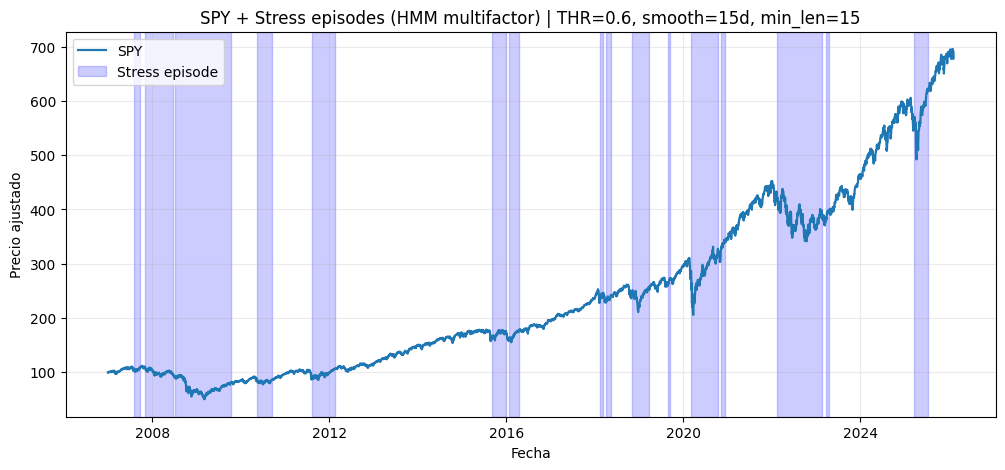

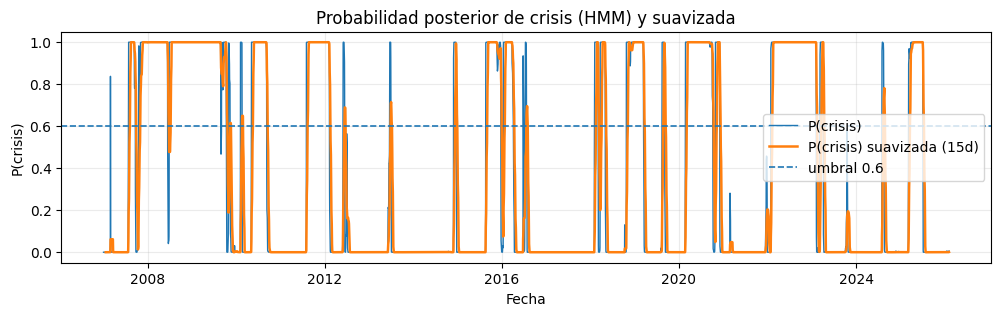

In [4]:
# =========================
# Parámetros (ajustables)
# =========================
START = "2007-01-01"
RV1 = 20          # RV corto (estrés agudo)
RV2 = 63          # RV medio (estrés persistente)
D_MACRO = 20      # cambios "mensuales" para FRED (evita ruido semanal)
N_STATES = 2
SEED = 42

SMOOTH = 15       # suavizado de prob. crisis
THR = 0.60        # umbral de crisis
MIN_LEN = 15      # mínimo días para episodio
GAP_TOL = 5       # fusionar episodios si gap <= GAP_TOL

# =========================
# 0) FIX: retornos SIN dropna global (para no recortar por ENPH)
# =========================
ret = np.log(px).diff()

# =========================
# 1) Features sistémicas (multifactor, interpretables)
# =========================
idx = px.index
feat = pd.DataFrame(index=idx)

# Mercado
spy = px["SPY"].ffill()
feat["SPY_ret"] = ret["SPY"]
feat[f"SPY_RV{RV1}"] = ret["SPY"].rolling(RV1).std() * np.sqrt(252)
feat[f"SPY_RV{RV2}"] = ret["SPY"].rolling(RV2).std() * np.sqrt(252)

# Crédito (cambios, no niveles)
hy = data["FRED_HY_OAS_SPREAD"].reindex(idx).ffill()
feat[f"dHY_OAS_{D_MACRO}d"] = hy.diff(D_MACRO)

# Tipos (cambios en pendiente, no nivel)
y10 = data["FRED_UST_10Y_YIELD"].reindex(idx).ffill()
y2  = data["FRED_UST_2Y_YIELD"].reindex(idx).ffill()
slope = (y10 - y2)
feat[f"dSLOPE_{D_MACRO}d"] = slope.diff(D_MACRO)

# “Flight to quality” (opcional pero suele ayudar)
if "IEF" in ret.columns:
    feat["IEF_ret"] = ret["IEF"]
if "GLD" in ret.columns:
    feat["GLD_ret"] = ret["GLD"]

# Recortamos a partir de START y quitamos NaNs solo aquí
feat = feat.loc[feat.index >= START].dropna()

print("Inicio efectivo (features HMM):", feat.index.min().date(), "| Fin:", feat.index.max().date())
print("Features:", list(feat.columns))

# Winsorización ligera para que un par de días extremos no dominen (opcional pero útil)
feat_clip = feat.copy()
for c in feat_clip.columns:
    lo, hi = feat_clip[c].quantile([0.01, 0.99])
    feat_clip[c] = feat_clip[c].clip(lo, hi)

# =========================
# 2) HMM (2 estados)
# =========================
scaler = StandardScaler()
Z = scaler.fit_transform(feat_clip.values)

hmm = GaussianHMM(
    n_components=N_STATES,
    covariance_type="full",
    n_iter=3000,
    random_state=SEED
)
hmm.fit(Z)

states = pd.Series(hmm.predict(Z), index=feat_clip.index, name="state_raw")
post = pd.DataFrame(hmm.predict_proba(Z), index=feat_clip.index, columns=[0, 1])

# Etiquetar crisis con criterio económico (vol alta + spread widening + peor retorno)
stats = pd.DataFrame({
    "mean_ret": feat_clip["SPY_ret"].groupby(states).mean(),
    "vol_RV20": feat_clip[f"SPY_RV{RV1}"].groupby(states).mean(),
    "mean_dHY": feat_clip[f"dHY_OAS_{D_MACRO}d"].groupby(states).mean()
})

# Score: estrés = vol alta + subida de spread + retorno medio más bajo
score = stats["vol_RV20"] + stats["mean_dHY"].clip(lower=0) - stats["mean_ret"]
crisis_state = int(score.idxmax())

p_crisis = post[crisis_state]
p_smooth = p_crisis.rolling(SMOOTH).mean()

stress01 = (p_smooth > THR).astype(int)

print("\nResumen por estado:\n", stats)
print("\nScore crisis:\n", score)
print("\nCrisis_state:", crisis_state)
print("\nTransmat:\n", hmm.transmat_)

# =========================
# 3) Convertir stress diario -> EPISODIOS (min duración + merge gaps)
# =========================
def build_episodes(stress: pd.Series, min_len=15, gap_tol=5):
    s = stress.astype(int).values
    t = stress.index.to_numpy()

    changes = np.diff(np.r_[0, s, 0])
    starts = np.where(changes == 1)[0]
    ends   = np.where(changes == -1)[0]  # exclusivo

    segs = []
    for a, b in zip(starts, ends):
        if (b - a) >= min_len:
            segs.append([a, b])

    if not segs:
        return []

    merged = [segs[0]]
    for a, b in segs[1:]:
        pa, pb = merged[-1]
        if (a - pb) <= gap_tol:
            merged[-1][1] = b
        else:
            merged.append([a, b])

    return [(t[a], t[b-1]) for a, b in merged]

episodes = build_episodes(stress01, min_len=MIN_LEN, gap_tol=GAP_TOL)
print("\nN episodios:", len(episodes))
print("Primeros:", episodes[:6])

# =========================
# 4) Plot: SPY + episodios
# =========================
spy_plot = px["SPY"].reindex(feat_clip.index).ffill()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(spy_plot.index, spy_plot.values, linewidth=1.6, label="SPY")

for (a, b) in episodes:
    ax.axvspan(a, b, alpha=0.20, color="blue", label="Stress episode")

# leyenda sin duplicados
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), loc="upper left")

ax.set_title(f"SPY + Stress episodes (HMM multifactor) | THR={THR}, smooth={SMOOTH}d, min_len={MIN_LEN}")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio ajustado")
ax.grid(True, alpha=0.25)
plt.show()

# Plot de probabilidad (diagnóstico)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(p_crisis.index, p_crisis, linewidth=1.0, label="P(crisis)")
ax.plot(p_smooth.index, p_smooth, linewidth=1.8, label=f"P(crisis) suavizada ({SMOOTH}d)")
ax.axhline(THR, linestyle="--", linewidth=1.2, label=f"umbral {THR}")
ax.set_title("Probabilidad posterior de crisis (HMM) y suavizada")
ax.set_xlabel("Fecha")
ax.set_ylabel("P(crisis)")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()


# Fase 2 — Anatomía del Riesgo 

En esta fase cuantificamos cómo cambian las distribuciones **individuales** de los retornos cuando el mercado pasa de *calma* a *crisis*.

Para cada activo calculamos, **condicional a cada estado** (Estado 0 = Calma, Estado 1 = Crisis):
- **Media** (retorno esperado diario)
- **Volatilidad** (desviación típica diaria)
- **Skewness** (asimetría)
- **Kurtosis (exceso)** (colas: >0 indica colas más pesadas que normal)

Además, respondemos:
1) ¿Cuánto aumenta la volatilidad de **HYG** al pasar de Estado 0 a Estado 1?  
2) ¿Sigue siendo **GLD** un activo refugio? (lo evaluamos por su media/vol en crisis y, como extra, su correlación con SPY en crisis).


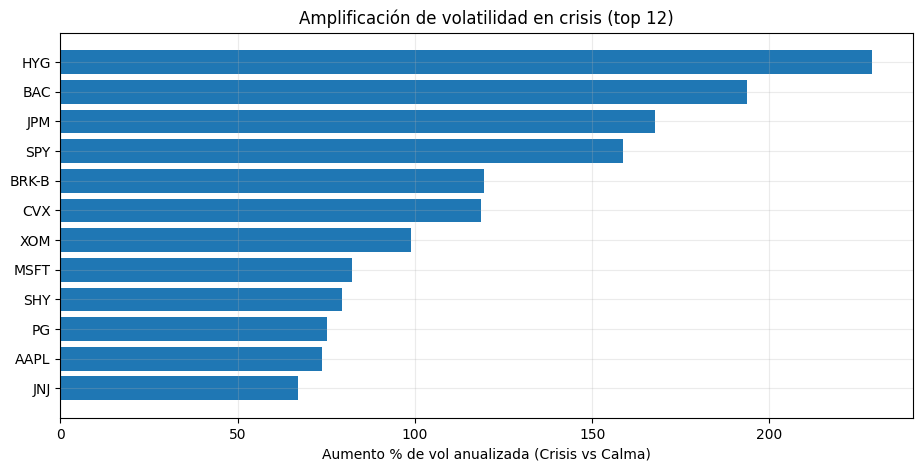

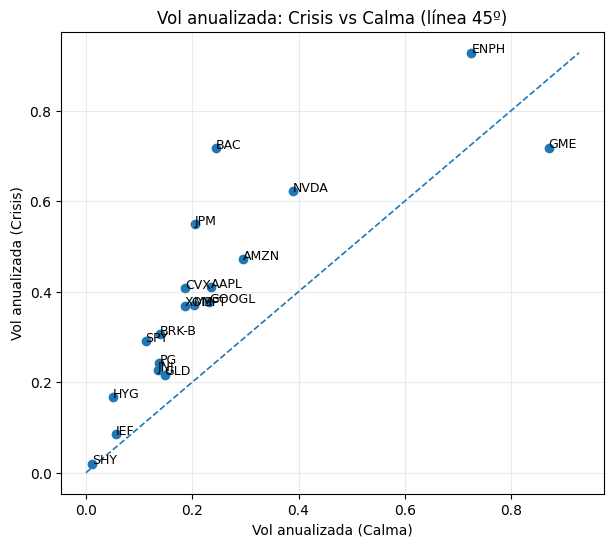

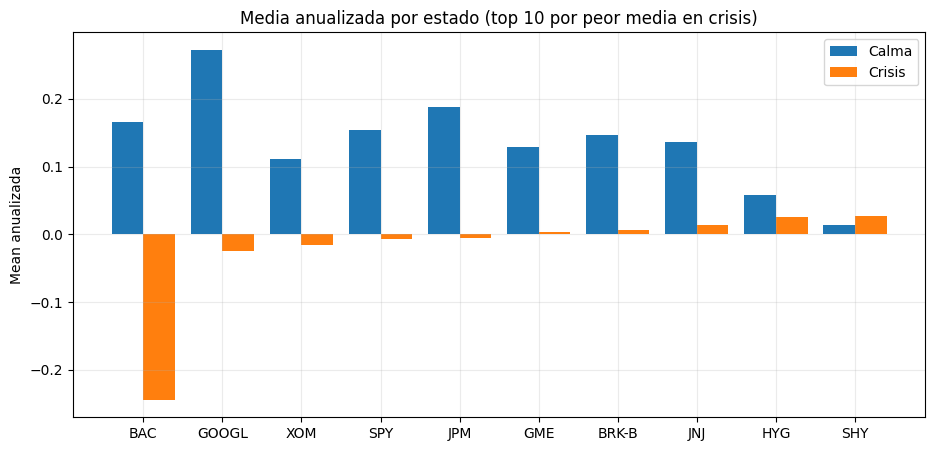

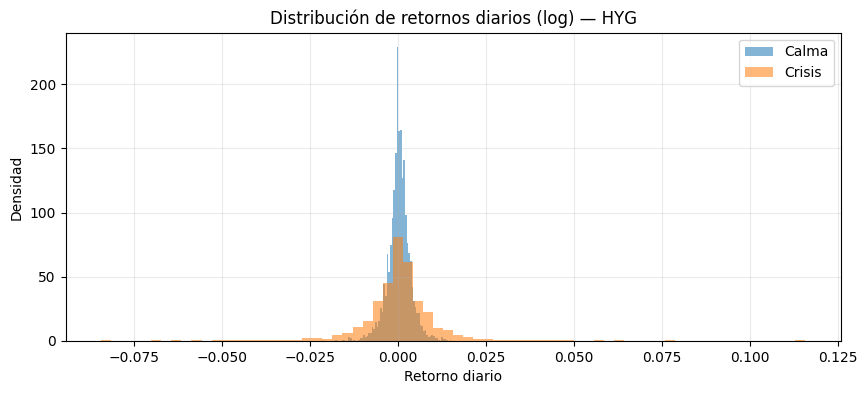

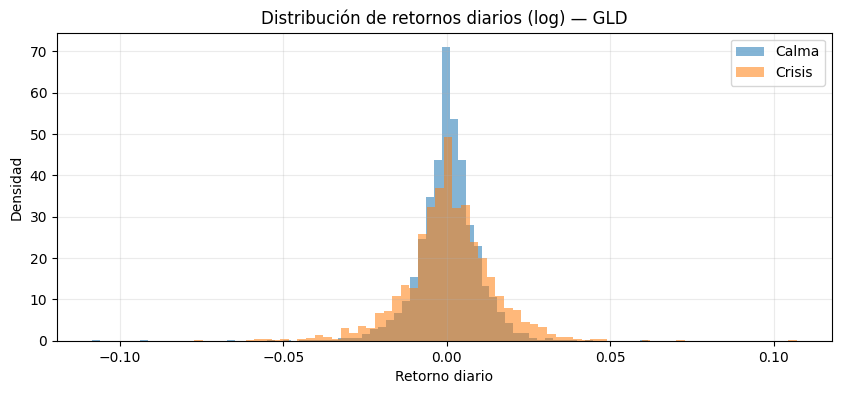

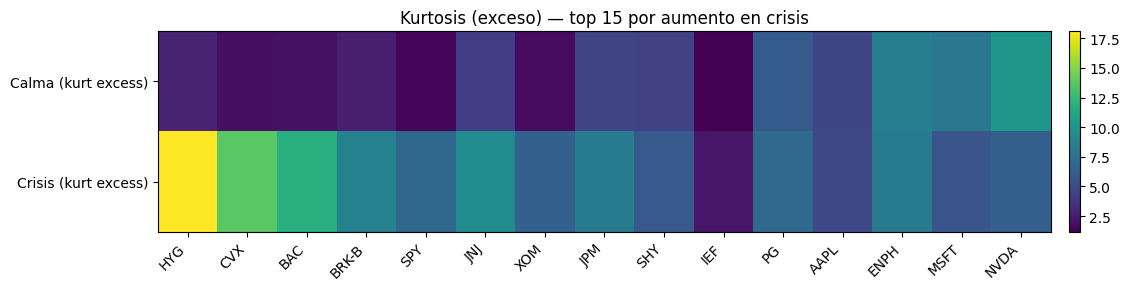


================= RESPUESTAS FASE 2 =================

(HYG) Vol anualizada Calma:  0.0508
(HYG) Vol anualizada Crisis: 0.1673
(HYG) Aumento (%):           229.06%  | Ratio: 3.291

(GLD) Mean anualizada Calma:  0.0783
(GLD) Mean anualizada Crisis: 0.1399  | Δ: 0.0616
(GLD) Vol anualizada Calma:   0.1481
(GLD) Vol anualizada Crisis:  0.2168  | Ratio: 1.463
(GLD vs SPY) Corr Calma: 0.098 | Corr Crisis: 0.035


In [7]:
# -----------------------------
# Checks
# -----------------------------
if "states" not in globals() or "crisis_state" not in globals():
    raise ValueError("No encuentro `states` y/o `crisis_state`. Ejecuta primero la Fase 1 (HMM).")

# -----------------------------
# 1) Estado 0/1: 0=Calma, 1=Crisis
# -----------------------------
S01 = (states == int(crisis_state)).astype(int)
S01.name = "state01"

# -----------------------------
# 2) Retornos del universo (log) sin dropna global
# -----------------------------
universe = [
    "AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GLD","GME","GOOGL","JNJ",
    "JPM","MSFT","NVDA","PG","XOM",
    "IEF","SHY","HYG","SPY"
]
universe = [t for t in universe if t in px.columns]

R = np.log(px[universe]).diff()  # SIN dropna global
common_idx = R.index.intersection(S01.index)
R = R.loc[common_idx]
S01 = S01.loc[common_idx]

# -----------------------------
# 3) Momentos condicionales por estado
# -----------------------------
def moments(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({
        "N": df.count(),
        "mean_d": df.mean(),
        "vol_d": df.std(),
        "skew": df.skew(),
        "kurt_excess": df.kurt()   # exceso de kurtosis (Fisher)
    })
    out["mean_ann"] = out["mean_d"] * 252
    out["vol_ann"]  = out["vol_d"] * np.sqrt(252)
    return out

mom_calm   = moments(R[S01==0]).add_prefix("calm_")
mom_crisis = moments(R[S01==1]).add_prefix("crisis_")

tab = pd.concat([mom_calm, mom_crisis], axis=1)

tab["vol_ratio"] = tab["crisis_vol_ann"] / tab["calm_vol_ann"]
tab["vol_increase_%"] = (tab["vol_ratio"] - 1.0) * 100
tab["mean_diff_ann"] = tab["crisis_mean_ann"] - tab["calm_mean_ann"]
tab["kurt_diff"] = tab["crisis_kurt_excess"] - tab["calm_kurt_excess"]
tab["skew_diff"] = tab["crisis_skew"] - tab["calm_skew"]

# Si algún activo tiene pocos datos en un estado, mejor filtrarlo un poco
MIN_N = 400
mask = (tab["calm_N"] >= MIN_N) & (tab["crisis_N"] >= MIN_N)
tab_f = tab[mask].copy()

# -----------------------------
# 4) VISUALES
# -----------------------------
# (A) Top "amplificación" de volatilidad
topN = 12
rank = tab_f.sort_values("vol_increase_%", ascending=False).head(topN)

fig, ax = plt.subplots(figsize=(11, 5))
ax.barh(rank.index[::-1], rank["vol_increase_%"][::-1])
ax.set_title(f"Amplificación de volatilidad en crisis (top {topN})")
ax.set_xlabel("Aumento % de vol anualizada (Crisis vs Calma)")
ax.grid(True, alpha=0.25)
plt.show()

# (B) Scatter: vol crisis vs vol calma (línea 45º)
fig, ax = plt.subplots(figsize=(7, 6))
x = tab_f["calm_vol_ann"].values
y = tab_f["crisis_vol_ann"].values
ax.scatter(x, y)

mx = np.nanmax([x.max(), y.max()])
ax.plot([0, mx], [0, mx], linestyle="--", linewidth=1.2)  # línea 45º

# Etiquetar solo algunos (los más relevantes) para no saturar
labels = tab_f.index.tolist()
for t in labels:
    ax.annotate(t, (tab_f.loc[t, "calm_vol_ann"], tab_f.loc[t, "crisis_vol_ann"]), fontsize=9)

ax.set_title("Vol anualizada: Crisis vs Calma (línea 45º)")
ax.set_xlabel("Vol anualizada (Calma)")
ax.set_ylabel("Vol anualizada (Crisis)")
ax.grid(True, alpha=0.25)
plt.show()

# (C) Mean anualizada: comparación Calma vs Crisis (top 10 por peor media en crisis)
topM = 10
rank_mean = tab_f.sort_values("crisis_mean_ann").head(topM)  # <- aquí definimos rank_mean

fig, ax = plt.subplots(figsize=(11, 5))
idx = np.arange(len(rank_mean))
ax.bar(idx - 0.2, rank_mean["calm_mean_ann"].values, width=0.4, label="Calma")
ax.bar(idx + 0.2, rank_mean["crisis_mean_ann"].values, width=0.4, label="Crisis")
ax.set_xticks(idx)
ax.set_xticklabels(rank_mean.index, rotation=0)
ax.set_title(f"Media anualizada por estado (top {topM} por peor media en crisis)")
ax.set_ylabel("Mean anualizada")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()


# (D) Distribuciones (hist) para HYG y GLD por estado
def plot_hist_asset(ticker, bins=70):
    if ticker not in R.columns:
        print(f"[WARN] {ticker} no está en retornos.")
        return
    r0 = R.loc[S01==0, ticker].dropna()
    r1 = R.loc[S01==1, ticker].dropna()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(r0.values, bins=bins, density=True, alpha=0.55, label="Calma")
    ax.hist(r1.values, bins=bins, density=True, alpha=0.55, label="Crisis")
    ax.set_title(f"Distribución de retornos diarios (log) — {ticker}")
    ax.set_xlabel("Retorno diario")
    ax.set_ylabel("Densidad")
    ax.grid(True, alpha=0.25)
    ax.legend()
    plt.show()

plot_hist_asset("HYG")
plot_hist_asset("GLD")

# (E) “Mapa rápido” de colas/asimetría (top por kurtosis diff)
topK = 15
rank_k = tab_f.sort_values("kurt_diff", ascending=False).head(topK)
vals = np.vstack([rank_k["calm_kurt_excess"].values, rank_k["crisis_kurt_excess"].values])

fig, ax = plt.subplots(figsize=(12, 2.6))
im = ax.imshow(vals, aspect="auto")
ax.set_yticks([0,1])
ax.set_yticklabels(["Calma (kurt excess)", "Crisis (kurt excess)"])
ax.set_xticks(np.arange(topK))
ax.set_xticklabels(rank_k.index, rotation=45, ha="right")
ax.set_title(f"Kurtosis (exceso) — top {topK} por aumento en crisis")
plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
plt.show()

# -----------------------------
# 5) Respuestas directas a las preguntas (HYG y GLD)
# -----------------------------
print("\n================= RESPUESTAS FASE 2 =================")

if "HYG" in tab.index:
    hyg = tab.loc["HYG"]
    print(f"\n(HYG) Vol anualizada Calma:  {hyg['calm_vol_ann']:.4f}")
    print(f"(HYG) Vol anualizada Crisis: {hyg['crisis_vol_ann']:.4f}")
    print(f"(HYG) Aumento (%):           {hyg['vol_increase_%']:.2f}%  | Ratio: {hyg['vol_ratio']:.3f}")
else:
    print("\n(HYG) No disponible en el dataset.")

if "GLD" in tab.index:
    gld = tab.loc["GLD"]
    print(f"\n(GLD) Mean anualizada Calma:  {gld['calm_mean_ann']:.4f}")
    print(f"(GLD) Mean anualizada Crisis: {gld['crisis_mean_ann']:.4f}  | Δ: {gld['mean_diff_ann']:.4f}")
    print(f"(GLD) Vol anualizada Calma:   {gld['calm_vol_ann']:.4f}")
    print(f"(GLD) Vol anualizada Crisis:  {gld['crisis_vol_ann']:.4f}  | Ratio: {gld['vol_ratio']:.3f}")

    # Extra: correlación GLD vs SPY condicional
    if "SPY" in R.columns:
        corr_calm = R.loc[S01==0, "GLD"].corr(R.loc[S01==0, "SPY"])
        corr_cris = R.loc[S01==1, "GLD"].corr(R.loc[S01==1, "SPY"])
        print(f"(GLD vs SPY) Corr Calma: {corr_calm:.3f} | Corr Crisis: {corr_cris:.3f}")
else:
    print("\n(GLD) No disponible en el dataset.")
